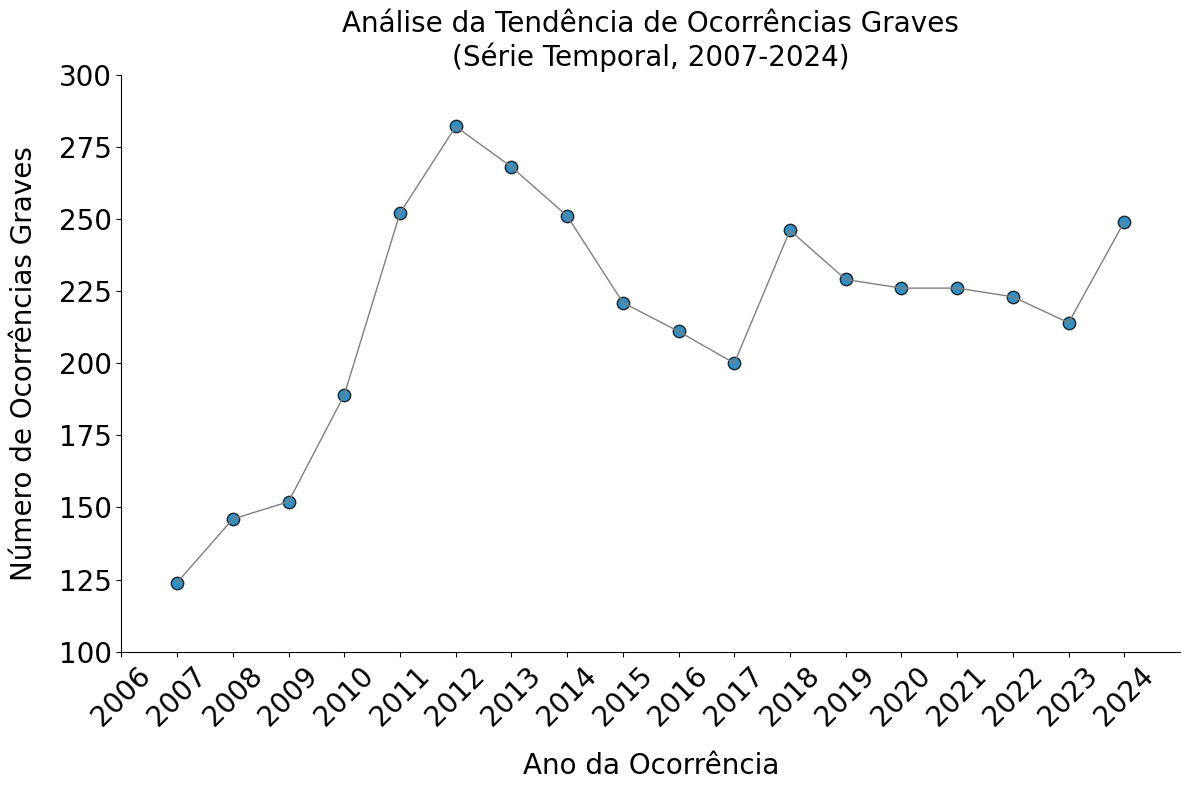

In [9]:
# -*- coding: utf8

from scipy import stats as ss
from numpy.testing import assert_equal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

plt.ion()
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

#DADOS
ocorrencias = pd.read_csv('ocorrencia.csv', encoding='latin1', sep=';')
ocorrencias_graves = ocorrencias[ocorrencias['ocorrencia_classificacao'].isin(['ACIDENTE', 'INCIDENTE GRAVE'])].copy() #filtrando as ocorrências graves
x = ocorrencias_graves[['ocorrencia_classificacao', 'ocorrencia_dia']].copy() #colunas necessárias
x['ocorrencia_dia'] = pd.to_datetime(x['ocorrencia_dia'], format='%d/%m/%Y') #tipo data
x['ano_ocorrencia'] = x['ocorrencia_dia'].dt.year #isolando o ano
y = x[x['ano_ocorrencia'] < 2025].copy() #excluindo 2025 pelo ano não estar completo
y = y.groupby('ano_ocorrencia').size() #agrupando
df = y.reset_index(name='contagem_ocorrencias') #pegando o número de ocorrências por ano

#GRÁFICO
x = df['ano_ocorrencia'].values #eixo x
y = df['contagem_ocorrencias'].values #eixo y

plt.xlim(2006, 2025)
plt.ylim(100, 300)
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y, color='gray', linewidth=1)
plt.xlabel('Ano da Ocorrência', labelpad=15)
plt.ylabel('Número de Ocorrências Graves', labelpad=15)
plt.title('Análise da Tendência de Ocorrências Graves\n(Série Temporal, 2007-2024)')
todos_os_anos = np.arange(2006, 2025, 1) #sequencia para o eixo x
plt.xticks(todos_os_anos, rotation=45)
despine()
plt.tight_layout()
plt.show()


In [ ]:
def least_squares_fit(x, y):
    correlationxy = ss.pearsonr(x, y)[0] 
    beta = correlationxy * np.std(y, ddof=1) / np.std(x, ddof=1) 
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

alpha, beta = least_squares_fit(x,y)

y_media = np.mean(y)
y_predito = alpha + beta * x
SSE = np.sum((y - y_predito)**2)
SST = np.sum((y - y_media)**2)
R2 = 1 - (SSE / SST)

print(alpha, beta, R2)

-7264.5190918472645 3.7120743034055725 0.21916013572999804


O coeficiente angular (betha_manual) é positivo (3.712) indicando uma correlação positiva médio ao longo do período. O valor baixo de R2 (0,2191) mostra que a relação entre ano da ocorrência e número de ocorrências graves não é linear e, portanto, uma reta tem baixo poder explicativo e não é ideal para esse caso. Usaremos uma curva.

In [12]:
#REGRESSÃO POLINOMIAL

#scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

x_reg = x.reshape(-1, 1) #transforma x em um formato de matriz, exigido pelo scikit-learn
modelo_polinomial = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()) #encontrando uma curva e calculando os coeficientes pelo método de mínimos quadrados
modelo_polinomial.fit(x_reg, y) #algoritmo de gradiente descendente do scikit-learn para encontrar os melhores valores de β0​,β1​,β2​ que minimizam o erro - treinamento do modelo
y_predito_poli = modelo_polinomial.predict(x_reg) #gerar valores de ŷ - é a sequencia de valores que formam a curva de regressão

beta_poli = modelo_polinomial.named_steps['linearregression'].coef_ #coeficientes de inclinação β1​ e β2​
alpha_poli = modelo_polinomial.named_steps['linearregression'].intercept_ #α - ponto de partida da curva

SSE_poli = np.sum((y - y_predito_poli)**2) 
y_media = np.mean(y)
R2_poli = 1 - (SSE_poli/ SST)

print(beta_poli, alpha_poli, R2_poli)


[ 0.00000000e+00  3.64861591e+03 -9.04218266e-01] -3680392.0165495174 0.49657741653065823


O Coeficiente Quadrático negativo de aprox. -0,90 indica uma curva de regressão que reflete uma tendência de diminuição do número de ocorrências após o pico. O R2 mostra que a curva de regressão polinomial explica aproximadamente 49,66% da variação total no número de ocorrências anuais, maior do que a reta representou anteriormente.

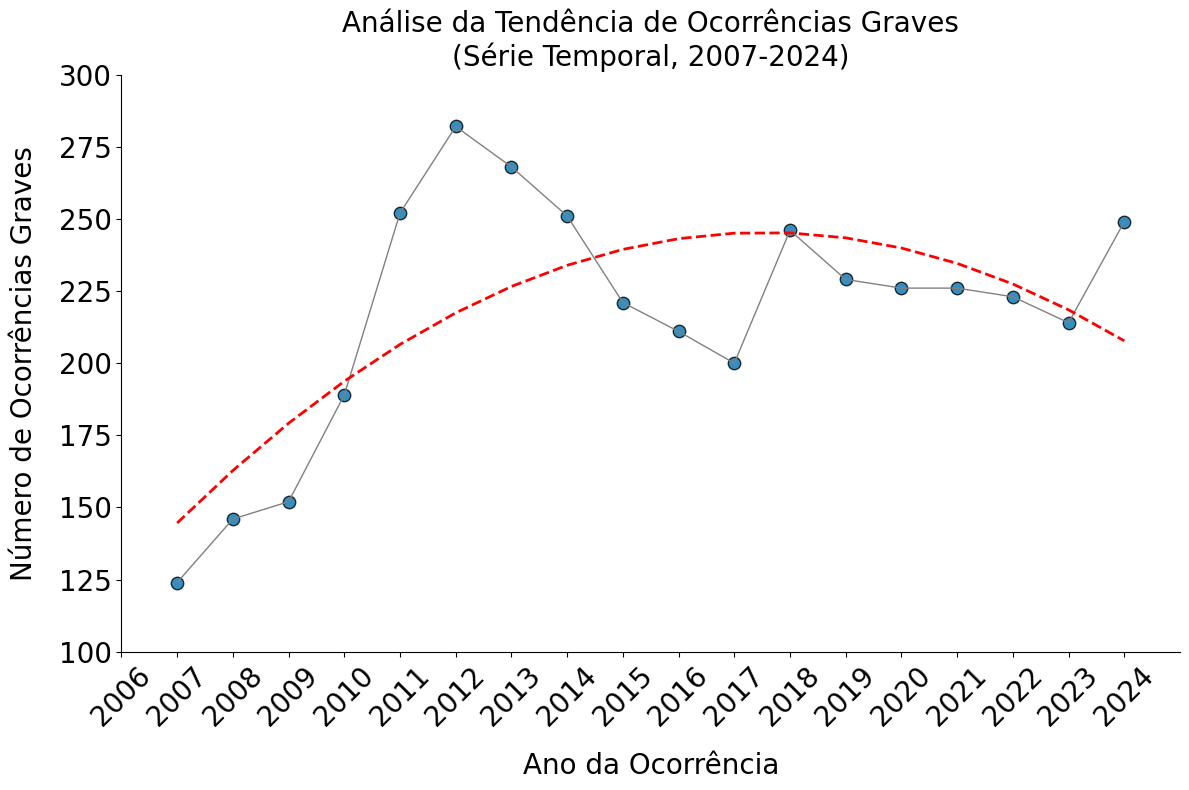

In [13]:
#GRÁFICO
plt.xlim(2006, 2025)
plt.ylim(100, 300)
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y, color='gray', linewidth=1)
plt.plot(x, y_predito_poli, color='red', linestyle='--', linewidth=2)
plt.xlabel('Ano da Ocorrência', labelpad=15)
plt.ylabel('Número de Ocorrências Graves', labelpad=15)
plt.title('Análise da Tendência de Ocorrências Graves\n(Série Temporal, 2007-2024)')
todos_os_anos = np.arange(2006, 2025, 1) #sequencia para o eixo x
plt.xticks(todos_os_anos, rotation=45)
despine()
plt.tight_layout()
plt.show()


In [ ]:
#PREVISÃO 2025 E IC

from sklearn.metrics import mean_squared_error
from scipy import stats

ano_previsao = 2025
x_predito = np.array([[ano_previsao]]) #formato 2D para o scikit-learn
previsao = modelo_polinomial.predict(x_predito) #modelo já treinado

print(previsao)

RMSE = np.sqrt(mean_squared_error(y, y_predito_poli)) #desvio padrão
t_score = stats.t.ppf(1 - (0.05 / 2), df=len(y) - 2) #t-student para um IC de 95% (aprox. 1,96)
margem_erro = t_score * RMSE #define os limites do intervalo

#limites do intervalo
min = previsao - margem_erro
max = previsao + margem_erro

print(margem_erro)
print(min, max)

[195.16421566]
61.87701090412864
[133.28720476] [257.04122657]
